# Cervical Cancer Analysis
## Alexander Munoz, Atousa Nourmahnad, Tina Zeina

In [41]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

In [2]:
# prettify graphs
def prettify_ax(ax):
    ''' make an axis pretty '''
    for spine in ax.spines.itervalues():
        spine.set_visible(False)
    ax.set_frameon=True
    ax.patch.set_facecolor('#eeeeef')
    ax.grid('on', color='w', linestyle='-', linewidth=1)
    ax.tick_params(direction='out')
    ax.set_axisbelow(True)
    
def simple_ax(figsize=(6,4), **kwargs):
    ''' single prettified axis '''
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, **kwargs)
    prettify_ax(ax)
    return fig, ax

In [4]:
# read in data
data = pd.read_csv('Data/UCI_data.csv', na_values='?')
print 'Shape: ', data.shape
data.head()

Shape:  (858, 36)


,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


***We can see that there are missing values in the dataset, we first investigate these.***
## Missing Data

In [5]:
# determine missing values per column
missings = np.zeros(data.shape[1])
for colnum in range(data.shape[1]):
    missings[colnum] = data.iloc[:,colnum].isnull().sum()/data.shape[0]

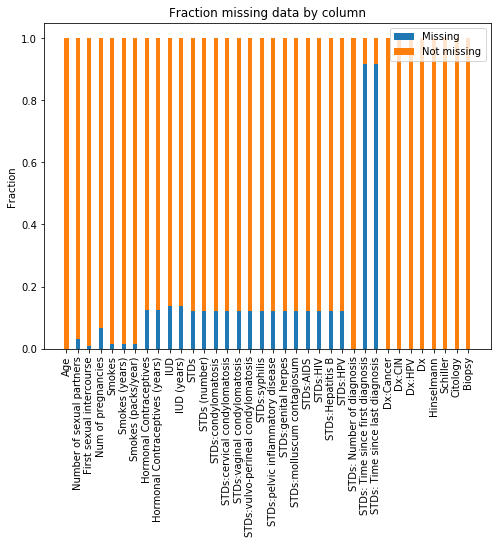

In [6]:
# plot
plt.figure(figsize=(8,6))
ind = np.arange(len(missings))
width = 0.35
p1 = plt.bar(ind, missings, width)
p2 = plt.bar(ind, 1-missings, width, bottom=missings)
plt.ylabel('Fraction')
plt.title('Fraction missing data by column')
plt.xticks(ind, data.columns.values, rotation=90)
plt.legend((p1[0], p2[0]), ('Missing', 'Not missing'))
#plt.savefig('Figures/col_miss1.png')
plt.show()

***We will first drop the two columns with many missing values. We will then investigate two methods of filling the other missing values.***

In [7]:
# drop STD columns
data_drop = data.drop(['STDs: Time since first diagnosis', 'STDs: Time since last diagnosis'], axis=1)
data_drop.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HPV,STDs: Number of diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,0.0,0,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,0.0,0,0,0,0,0,0,0,0,0


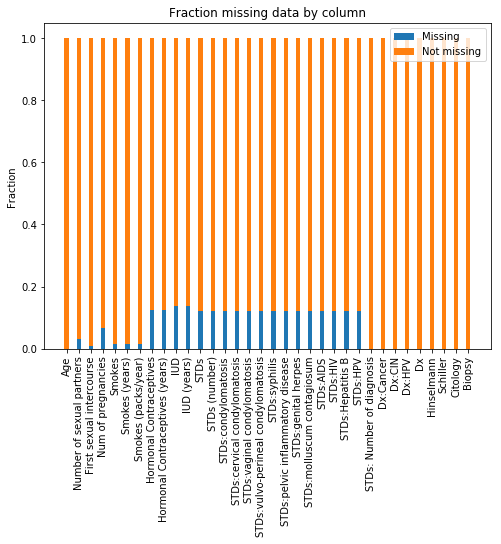

In [8]:
# plot
missings = np.zeros(data_drop.shape[1])
for colnum in range(data_drop.shape[1]):
    missings[colnum] = data_drop.iloc[:,colnum].isnull().sum()/data_drop.shape[0]

plt.figure(figsize=(8,6))
ind = np.arange(len(missings))
width = 0.35
p1 = plt.bar(ind, missings, width)
p2 = plt.bar(ind, 1-missings, width, bottom=missings)
plt.ylabel('Fraction')
plt.title('Fraction missing data by column')
plt.xticks(ind, data_drop.columns.values, rotation=90)
plt.legend((p1[0], p2[0]), ('Missing', 'Not missing'))
#plt.savefig('Figures/col_miss2.png')
plt.show()

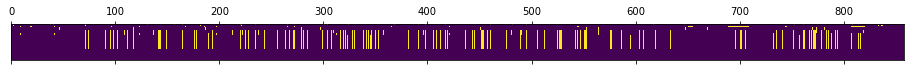

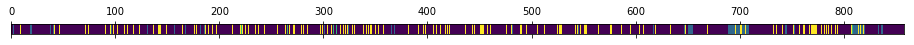

In [9]:
# plot be sample
missings = np.zeros((data_drop.shape[0], data_drop.shape[1]+1))
for colnum in range(data_drop.shape[1]):
    colcurr = data_drop.iloc[:,colnum]
    missings[:,colnum] = data_drop.iloc[:,colnum].isnull().astype('int')

plt.figure()
plt.matshow(missings.T)
plt.yticks([])
#plt.savefig('Figures/missings1.png')

plt.figure()
summed = np.sum(missings,1)[:,np.newaxis]
plt.matshow(np.repeat(summed,10,axis=1).T, cmap='viridis', vmin=0, vmax=3)
plt.yticks([])
#plt.savefig('Figures/missings2.png')
plt.show()

In [10]:
# drop extra datacolumns
data_drop = data_drop.dropna()

In [11]:
# train test split
train_id = int(0.7*data_drop.shape[0])
idx = data_drop.index.values
np.random.shuffle(idx)
train = data_drop.loc[idx[:train_id],:]
test = data_drop.loc[idx[train_id:],:]
train.to_csv('Data/train.csv')
test.to_csv('Data/test.csv')

## Inspect Data

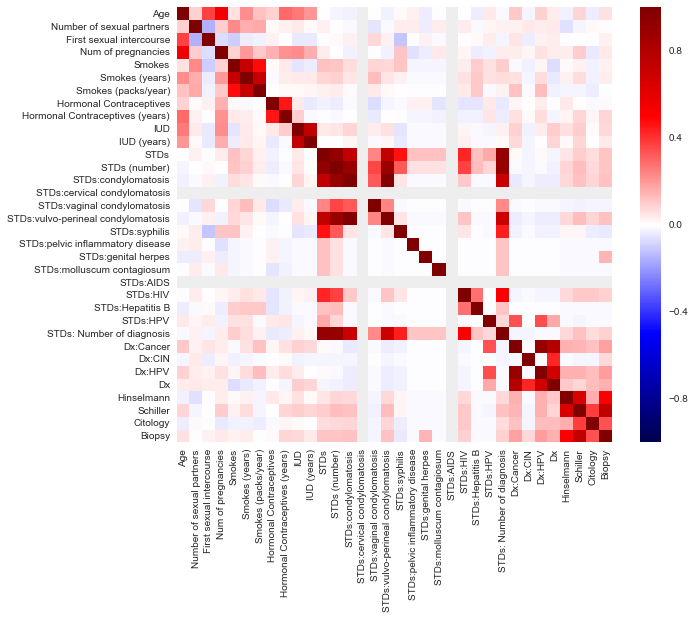

In [25]:
f,a = simple_ax(figsize=(10,8))
sns.heatmap(data_drop.corr(), vmax=1, square=True, cmap='seismic')
#plt.savefig('Figures/correlations.png')
plt.show()

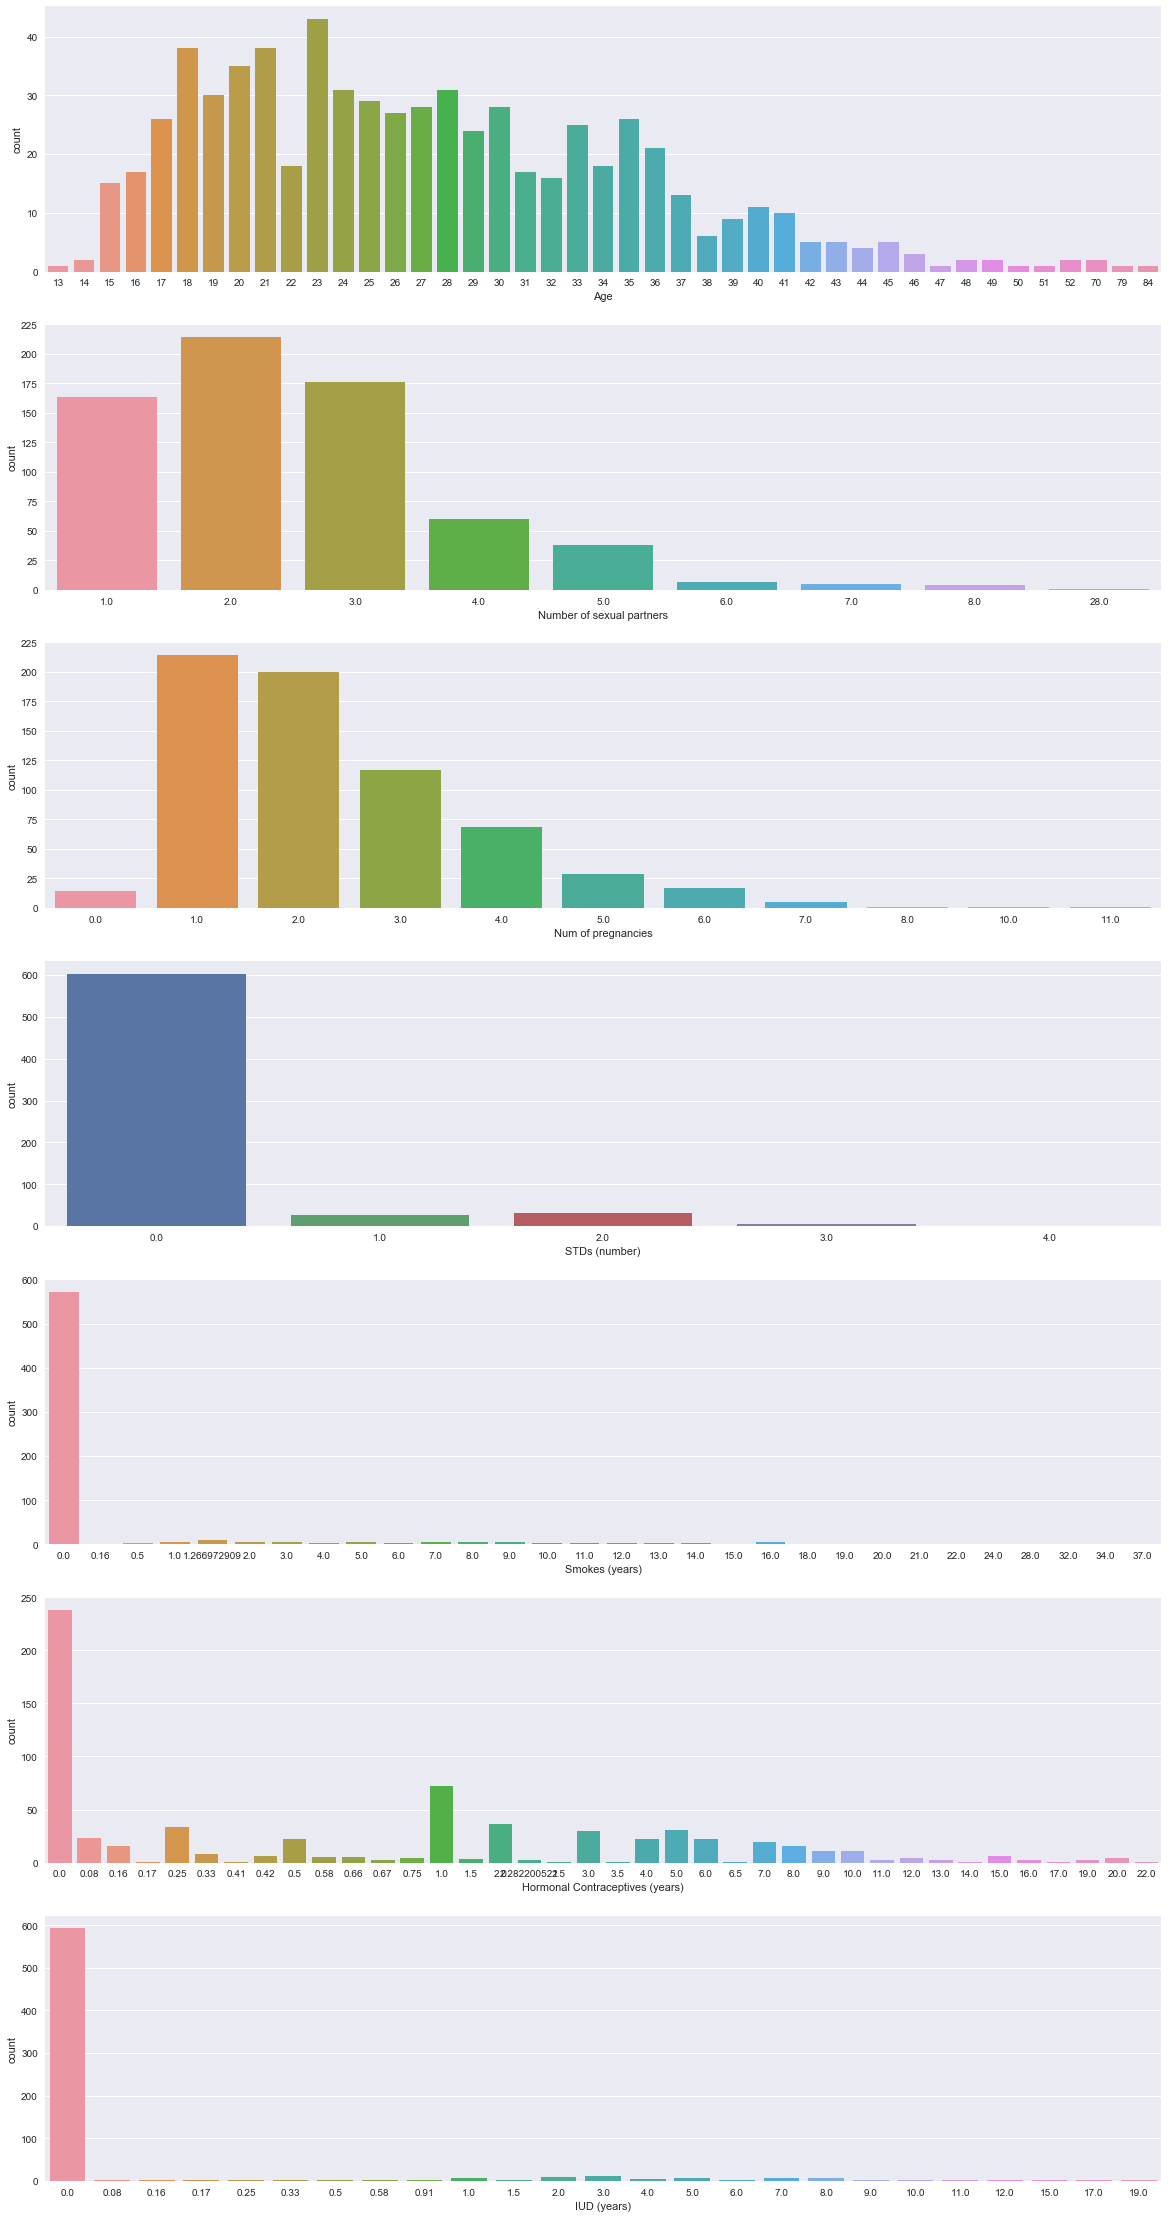

In [39]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7) = plt.subplots(7,1,figsize=(20,40))
sns.countplot(data_drop['Age'], ax=ax1)
sns.countplot(data_drop['Number of sexual partners'], ax=ax2)
sns.countplot(data_drop['Num of pregnancies'], ax=ax3)
sns.countplot(data_drop['STDs (number)'], ax=ax4)
sns.countplot(data_drop['Smokes (years)'], ax=ax5)
sns.countplot(data_drop['Hormonal Contraceptives (years)'], ax=ax6)
sns.countplot(data_drop['IUD (years)'], ax=ax7)
#plt.savefig('Figures/data_peek.png')
plt.show()

## Build Neural Network Perceptron Model

In [40]:
X_train = train.iloc[:,:-4].values
y_train = train.iloc[:,-4:].values
X_test = test.iloc[:,:-4].values
y_test = test.iloc[:,-4:].values
print 'X_train:', X_train.shape, '| y_train:', y_train.shape
print 'X_test:', X_test.shape, '| y_test:', y_test.shape

X_train: (467, 30) | y_train: (467, 4)
X_test: (201, 30) | y_test: (201, 4)


In [516]:
best = ()
i = 1
for nodes in [2,4,8,12,16,24,32,64,128]:
    for weight in [1.,5.,10.,15.,20.,25.,50.]:
        for epochs in [100,200,300]:
            model = Sequential()
            model.add(Dense(nodes, input_dim=X_train.shape[1]))
            model.add(Activation('relu'))
            model.add(Dense(1))
            model.add(Activation('sigmoid'))
            model.compile(optimizer='rmsprop',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])
            weights = {0:1., 1:weight}
            history = model.fit(X_train, y_train[:,3], epochs=epochs, class_weight=weights, verbose=0)
            decs = model.predict(X_test)
            roc = roc_curve(y_test[:,3], decs)
            auc = roc_auc_score(y_test[:,3], decs)
            if best==() or auc>best[0]:
                best=(auc,roc,history,model,nodes,weight,epochs)
            print i, '/ 189 done.',
            i += 1

1 / 189 done. 2 / 189 done. 3 / 189 done. 4 / 189 done. 5 / 189 done. 6 / 189 done. 7 / 189 done. 8 / 189 done. 9 / 189 done. 10 / 189 done. 11 / 189 done. 12 / 189 done. 13 / 189 done. 14 / 189 done. 15 / 189 done. 16 / 189 done. 17 / 189 done. 18 / 189 done. 19 / 189 done. 20 / 189 done. 21 / 189 done. 22 / 189 done. 23 / 189 done. 24 / 189 done. 25 / 189 done. 26 / 189 done. 27 / 189 done. 28 / 189 done. 29 / 189 done. 30 / 189 done. 31 / 189 done. 32 / 189 done. 33 / 189 done. 34 / 189 done. 35 / 189 done. 36 / 189 done. 37 / 189 done. 38 / 189 done. 39 / 189 done. 40 / 189 done. 41 / 189 done. 42 / 189 done. 43 / 189 done. 44 / 189 done. 45 / 189 done. 46 / 189 done. 47 / 189 done. 48 / 189 done. 49 / 189 done. 50 / 189 done. 51 / 189 done. 52 / 189 done. 53 / 189 done. 54 / 189 done. 55 / 189 done. 56 / 189 done. 57 / 189 done. 58 / 189 done. 59 / 189 done. 60 / 189 done. 61 / 189 done. 62 / 189 done. 63 / 189 done. 64 / 189 done. 65 / 189 done. 66 / 189 done. 67 / 189 done. 68 /

In [520]:
(auc,roc,history,model,nodes,weight,epochs) = best
print "Nodes:", nodes, "| Weight:", weight, "| Epochs:", epochs

Nodes: 64 | Weight: 1.0 | Epochs: 300


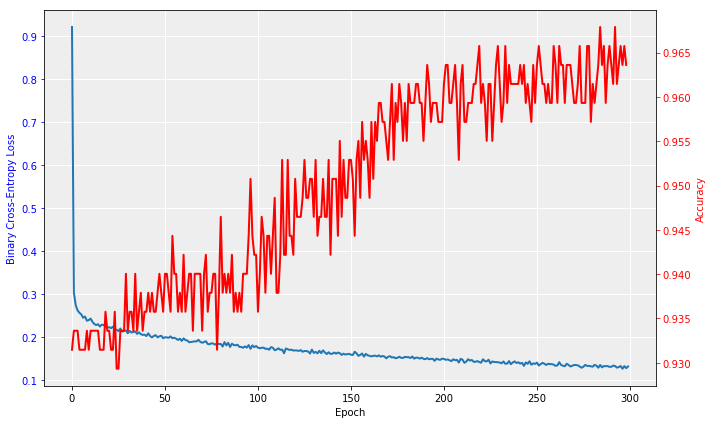

In [519]:
# plot errors
fig, ax1 = simple_ax(figsize=(10,6))
ax1.plot(history.history['loss'], label='loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Binary Cross-Entropy Loss', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
plt.plot(history.history['acc'][1:], 'r-', label='accuracy', linewidth=2)
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
#plt.savefig('Figures/error2.png')
plt.show()

In [521]:
# predict on test set
verdicts = np.zeros(y_test.shape)
preds = (model.predict(X_test)>0.5).astype('int')
for e,pred in enumerate(preds):
    verdicts[e,:] = pred==y_test[e,:]

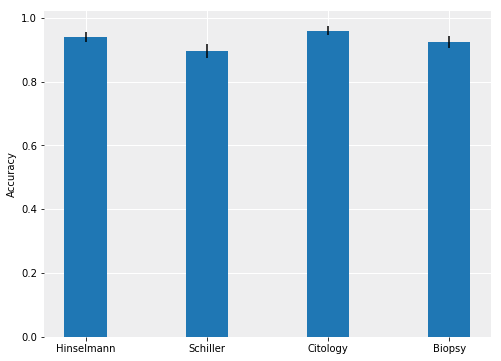

In [523]:
avg = np.sum(verdicts,0)/verdicts.shape[0]
stdev = np.std(verdicts,0)/np.sqrt(verdicts.shape[0])
width = 0.35

f,a = simple_ax(figsize=(8,6))
plt.bar(np.arange(4), avg, width, yerr=stdev)
plt.xticks(np.arange(4))
a.set_xticklabels(train.columns[-4:])
plt.ylabel('Accuracy')
#plt.savefig('Figures/MLP_accuracies.png')
plt.show()

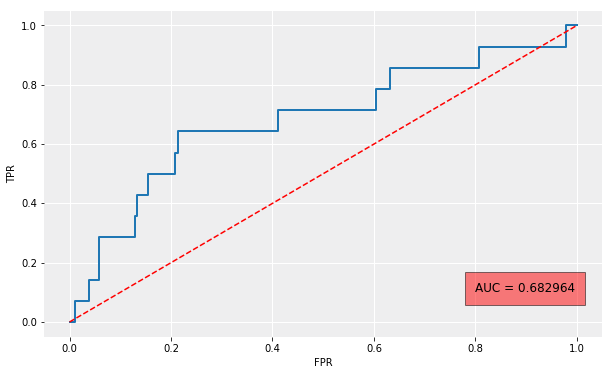

In [525]:
decs = model.predict(X_test)
roc = roc_curve(y_test[:,3], decs)
auc = roc_auc_score(y_test[:,3], decs)

f,a = simple_ax(figsize=(10,6))
plt.plot(roc[0], roc[1], linewidth=2)
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
a.text(0.8, 0.1, 'AUC = %f'%auc, fontsize=12, bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
#plt.savefig('Figures/mlp_roc.png')
plt.show()

# Logistic Regression

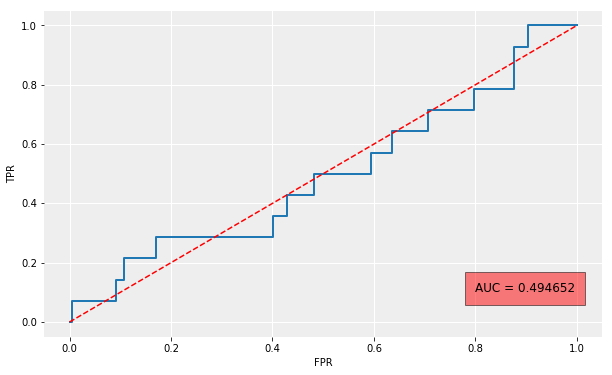

In [437]:
col = 3
logistic = LogisticRegression()
logistic.fit(X_train, y_train[:,col])
decs = logistic.decision_function(X_test)

roc = roc_curve(y_test[:,col], decs)
auc = roc_auc_score(y_test[:,col], decs)
f,a = simple_ax(figsize=(10,6))
plt.plot(roc[0], roc[1], linewidth=2)
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
a.text(0.8, 0.1, 'AUC = %f'%auc, fontsize=12, bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
#plt.savefig('Figures/logistic_roc.png')
plt.show()

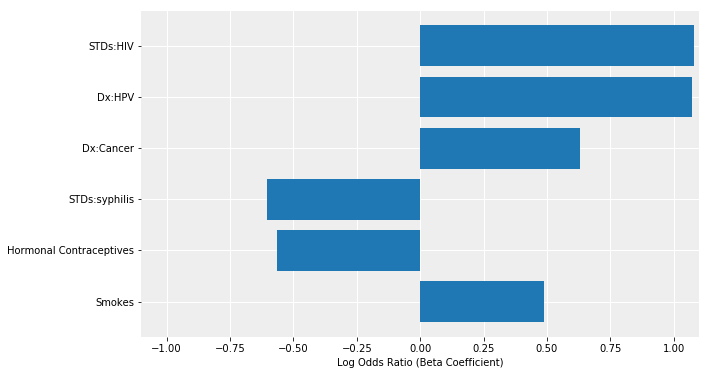

In [306]:
coefs = logistic.coef_[0]
idxx = [0,1,3,4,5,7]
coefs_idxsort = np.argsort(np.abs(coefs))[::-1]
coefs_labels = train.columns.values[coefs_idxsort][idxx]
coefs = coefs[coefs_idxsort][idxx]
f,a = simple_ax(figsize=(10,6))
plt.barh(np.arange(len(coefs)), coefs)
plt.xlim([-1.1,1.1])
a.invert_yaxis()
plt.xlabel('Log Odds Ratio (Beta Coefficient)')
a.set_yticks(np.arange(0,6))
a.set_yticklabels(coefs_labels)
#plt.savefig('Figures/logistic_coefs.png')
plt.show()

# Ridge Regression

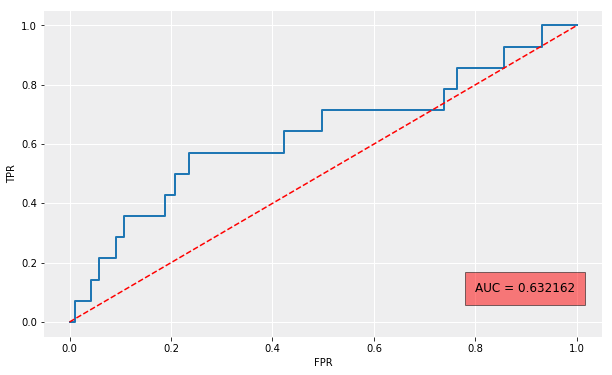

In [438]:
ridge = RidgeClassifier(normalize=True)
ridge.fit(X_train, y_train[:,col])
decs = ridge.decision_function(X_test)

roc = roc_curve(y_test[:,col], decs)
auc = roc_auc_score(y_test[:,col], decs)
f,a = simple_ax(figsize=(10,6))
plt.plot(roc[0], roc[1], linewidth=2)
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
a.text(0.8, 0.1, 'AUC = %f'%auc, fontsize=12, bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
#plt.savefig('Figures/ridge_roc.png')
plt.show()

# Random Forest

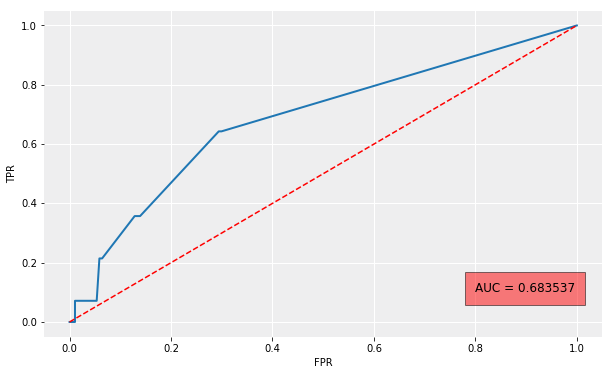

In [439]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train[:,col])
decs = rf.predict_proba(X_test)[:,1]

roc = roc_curve(y_test[:,col], decs)
auc = roc_auc_score(y_test[:,col], decs)
f,a = simple_ax(figsize=(10,6))
plt.plot(roc[0], roc[1], linewidth=2)
plt.plot([0, 1], [0, 1], color='r', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
a.text(0.8, 0.1, 'AUC = %f'%auc, fontsize=12, bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
#plt.savefig('Figures/rf_roc.png')
plt.show()